<a href="https://colab.research.google.com/github/Andre-lzf/projeto/blob/main/smartgrade_Uni9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
# Célula 1 - configurações iniciais para mostrar gráficos no notebook
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 100  # gráficos com boa resolução


In [29]:
# Célula 2 - criar estrutura de pastas do projeto
import os
os.makedirs("src", exist_ok=True)
os.makedirs("data/raw", exist_ok=True)
os.makedirs("data/processed", exist_ok=True)
os.makedirs("models", exist_ok=True)
os.makedirs("reports/figures", exist_ok=True)
print("Pastas criadas: src, data/raw, data/processed, models, reports/figures")


Pastas criadas: src, data/raw, data/processed, models, reports/figures


In [30]:
# Célula 3 - gerar dataset sintético e salvar em data/raw/alunos.csv
import numpy as np
import pandas as pd

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

n = 500
horas_estudo = np.clip(np.random.normal(10, 4, n), 0, 40)
faltas = np.random.poisson(3, n)
nota1 = np.clip(np.random.normal(6.5, 2.0, n), 0, 10)
nota2 = np.clip(np.random.normal(6.8, 2.0, n), 0, 10)
atividades_entregues = np.clip(np.random.binomial(10, 0.7, n), 0, 10)

score = 0.4*(nota1+nota2) + 0.3*(horas_estudo/4) - 0.5*faltas + 0.2*(atividades_entregues)
prob = 1/(1+np.exp(-(score-10)))
aprovado = (prob + np.random.normal(0,0.1,n) > 0.5).astype(int)
df['aprovado'].value_counts()
df.head()



df = pd.DataFrame({
    "horas_estudo": np.round(horas_estudo,2),
    "faltas": faltas,
    "nota1": np.round(nota1,2),
    "nota2": np.round(nota2,2),
    "atividades_entregues": atividades_entregues,
    "aprovado": aprovado
})

df.to_csv("data/raw/alunos.csv", index=False)
print("Dataset criado e salvo em data/raw/alunos.csv")


Dataset criado e salvo em data/raw/alunos.csv


In [31]:
# Célula 4 - carregar e mostrar os dados
import pandas as pd
from IPython.display import display

df = pd.read_csv("data/raw/alunos.csv")
print("Tamanho do dataset:", df.shape)
display(df.head())
print("\nContagem da variável alvo (aprovado):")
print(df['aprovado'].value_counts())


Tamanho do dataset: (500, 6)


,horas_estudo,faltas,nota1,nota2,atividades_entregues,aprovado
0,11.99,5,5.40,8.99,5,0
1,9.45,1,4.06,5.55,8,0
2,12.59,1,5.48,4.16,6,0
3,16.09,2,6.20,6.39,7,0
4,9.06,2,5.59,5.20,7,0



Contagem da variável alvo (aprovado):
aprovado
0    498
1      2
Name: count, dtype: int64


In [32]:
# Célula 5 - pré-processamento e split treino/teste
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = df.drop("aprovado", axis=1)
y = df["aprovado"]

scaler = StandardScaler()
X_scaled = X.copy()
X_scaled[["horas_estudo","nota1","nota2","atividades_entregues"]] = scaler.fit_transform(
    X_scaled[["horas_estudo","nota1","nota2","atividades_entregues"]]
)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)
print("Tamanho treino:", X_train.shape, "Tamanho teste:", X_test.shape)


Tamanho treino: (400, 5) Tamanho teste: (100, 5)


In [33]:
# Célula 6 - treinar modelos
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
import joblib

dt = DecisionTreeClassifier(max_depth=5, random_state=42)
dt.fit(X_train, y_train)

lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train, y_train)

joblib.dump(dt, "models/decision_tree_model.pkl")
joblib.dump(lr, "models/logistic_model.pkl")

print("Modelos treinados e salvos em /models")


Modelos treinados e salvos em /models


In [34]:
# Célula 7 - avaliar modelos e imprimir métricas
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

models = {"Decision Tree": dt, "Logistic Regression": lr}
results = {}

for name, model in models.items():
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    results[name] = {"accuracy": acc, "f1": f1, "confusion_matrix": cm}
    print(f"--- {name} ---")
    print("Accuracy:", acc)
    print("F1:", f1)
    print("Confusion matrix:\n", cm)
    print(classification_report(y_test, y_pred))
    print("-"*40)

print("=== RESUMO DAS MÉTRICAS ===")
for name, r in results.items():
    print(f"{name}: Accuracy={r['accuracy']:.3f} | F1={r['f1']:.3f}")


--- Decision Tree ---
Accuracy: 0.99
F1: 0.0
Confusion matrix:
 [[99  1]
 [ 0  0]]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       100
           1       0.00      0.00      0.00         0

    accuracy                           0.99       100
   macro avg       0.50      0.49      0.50       100
weighted avg       1.00      0.99      0.99       100

----------------------------------------
--- Logistic Regression ---
Accuracy: 1.0
F1: 0.0
Confusion matrix:
 [[100]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       100

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100

----------------------------------------
=== RESUMO DAS MÉTRICAS ===
Decision Tree: Accuracy=0.990 | F1=0.000
Logistic Regression: Accuracy=1.000 | F1=0.000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.p

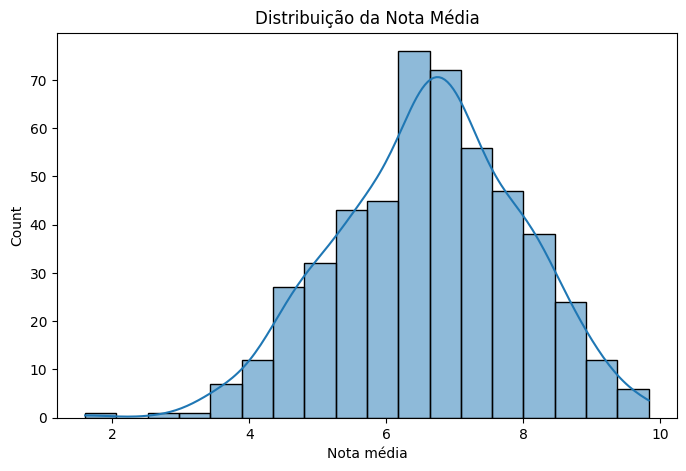

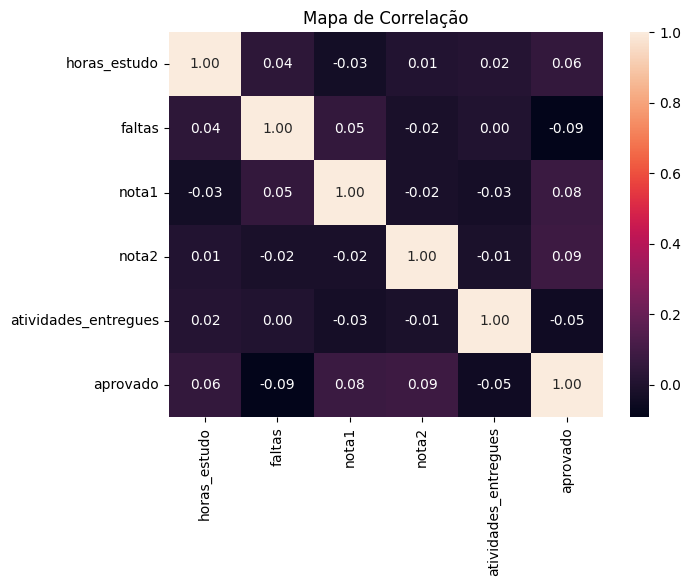

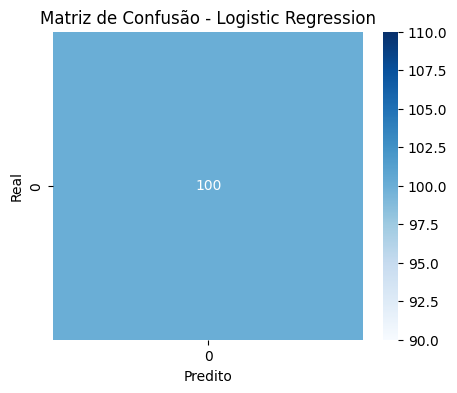

In [35]:
# Célula 8 - gerar e mostrar gráficos
import matplotlib.pyplot as plt
import seaborn as sns
import os

os.makedirs("reports/figures", exist_ok=True)

# 1) Distribuição da nota média
df["nota_media"] = (df["nota1"] + df["nota2"]) / 2
plt.figure(figsize=(8,5))
sns.histplot(df["nota_media"], kde=True)
plt.title("Distribuição da Nota Média")
plt.xlabel("Nota média")
plt.savefig("reports/figures/distribuicao_notas.png", bbox_inches="tight")
plt.show()

# 2) Heatmap de correlação
plt.figure(figsize=(7,5))
corr = df.drop(columns=["nota_media"]).corr()
sns.heatmap(corr, annot=True, fmt=".2f")
plt.title("Mapa de Correlação")
plt.savefig("reports/figures/correlacao.png", bbox_inches="tight")
plt.show()

# 3) Matriz de confusão do melhor modelo
best_model_name = max(results.keys(), key=lambda k: results[k]["accuracy"])
best_cm = results[best_model_name]["confusion_matrix"]

plt.figure(figsize=(5,4))
sns.heatmap(best_cm, annot=True, fmt="d", cmap="Blues")
plt.title(f"Matriz de Confusão - {best_model_name}")
plt.xlabel("Predito")
plt.ylabel("Real")
plt.savefig("reports/figures/matriz_confusao.png", bbox_inches="tight")
plt.show()


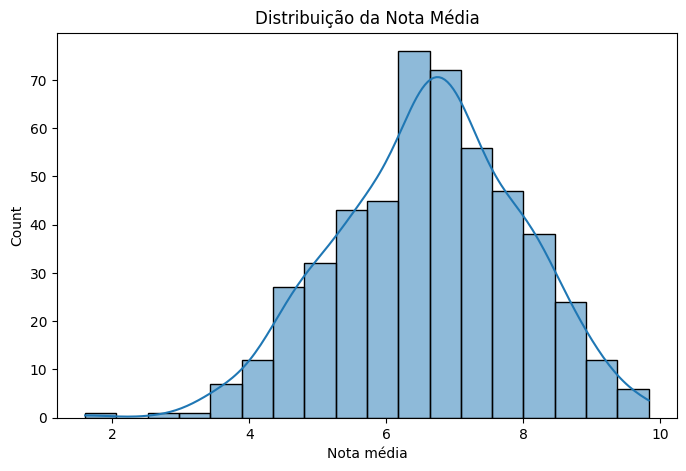

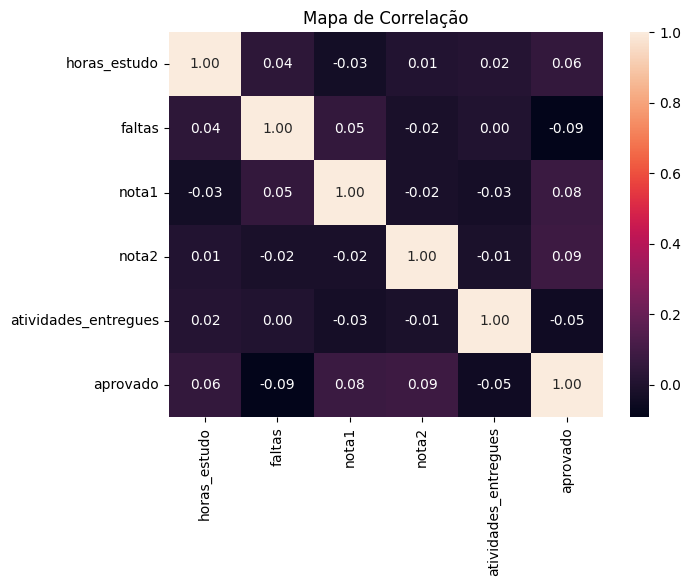

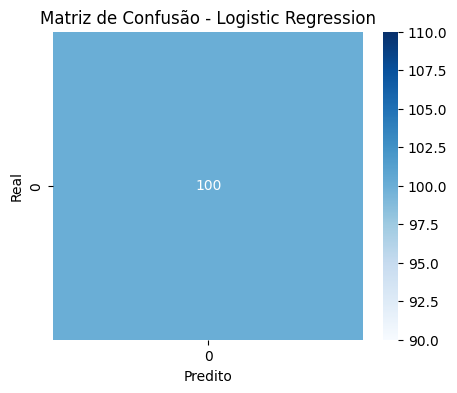

In [36]:
from IPython.display import Image, display
display(Image("reports/figures/distribuicao_notas.png"))
display(Image("reports/figures/correlacao.png"))
display(Image("reports/figures/matriz_confusao.png"))


In [37]:
# Célula 10 - resumo dos arquivos gerados
print("Arquivos gerados:")
for root, dirs, files in os.walk(".", topdown=True):
    if any(x in root for x in ["models","reports/figures","data/raw"]):
        print(root + ":")
        for f in files:
            if f.endswith(".pkl") or f.endswith(".png") or f.endswith(".csv"):
                print("  -", f)


Arquivos gerados:
./reports/figures:
  - distribuicao_notas.png
  - matriz_confusao.png
  - correlacao.png
./data/raw:
  - alunos.csv
./models:
  - logistic_model.pkl
  - decision_tree_model.pkl
